In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import xarray as xr

from matplotlib.patches import Polygon
from typing import Tuple

sys.executable

'D:\\SynDocs\\Research\\BaPSF\\_repos\\bapsf_motion\\.venvs\\py310_dev\\Scripts\\python.exe'

In [3]:
try:
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
except ModuleNotFoundError:
    from pathlib import Path

    HERE = Path().cwd()
    BAPSF_MOTION = (HERE / ".." / ".." / ".." ).resolve()
    sys.path.append(str(BAPSF_MOTION))
    
    from bapsf_motion.motion_builder.exclusions import CircularExclusion, DividerExclusion
    

In [4]:
plt.rcParams.update(
    {
        # "figure.figsize": [12, 0.56 * 12],
        "figure.figsize": [10, 0.8 * 10],
        "font.size": 16,
    }
)

## Prototyping the Shadow

#### Setup

In [5]:
from bapsf_motion.motion_builder.exclusions import LaPDXYExclusion, CircularExclusion

Create a staring blank (all `True`) mask.

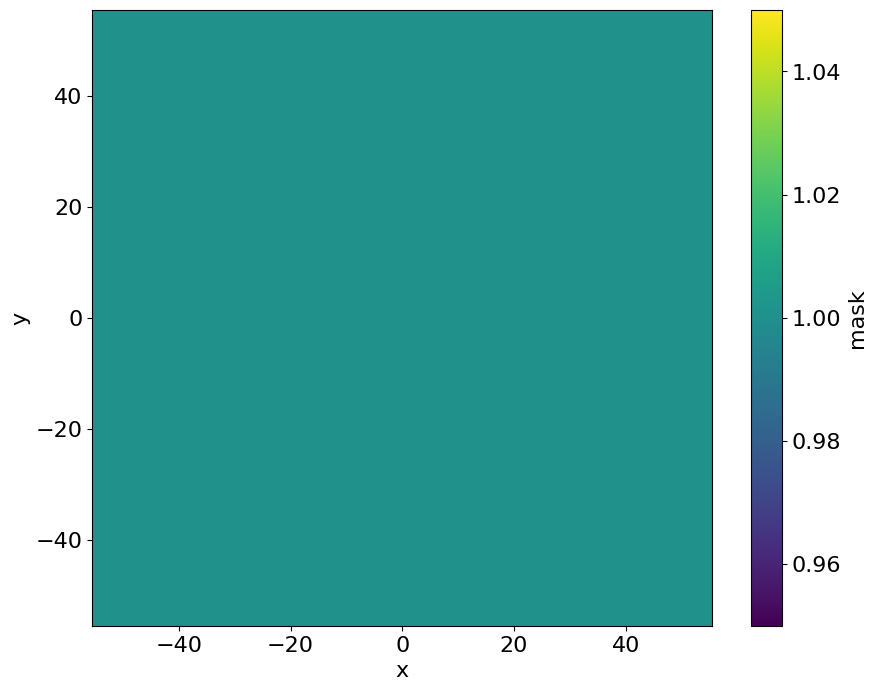

In [464]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

Populate the mask with a `LaPDXYExclusion` and `CircularExclusion`.  `CircularExclusion` is the element we will want to shadow.

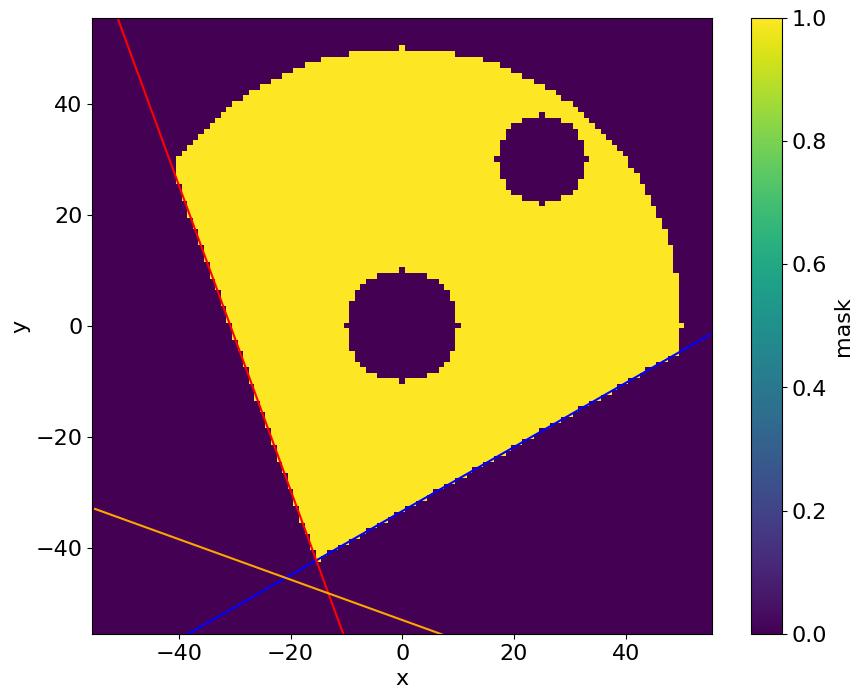

In [465]:
# ex = LaPDXYExclusion(ds, pivot_radius=20)
ex = LaPDXYExclusion(ds, port_location=250, pivot_radius=45)
exC = CircularExclusion(ds, radius=10, center=(0,0), exclude="inside")
exC2 = CircularExclusion(ds, radius=8, center=(25,30), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [466]:
ds

<xarray.Dataset> Size: 51kB
Dimensions:   (x: 111, y: 111)
Coordinates:
  * x         (x) float64 888B -55.0 -54.0 -53.0 -52.0 ... 52.0 53.0 54.0 55.0
  * y         (y) float64 888B -55.0 -54.0 -53.0 -52.0 ... 52.0 53.0 54.0 55.0
Data variables:
    mask      (x, y) bool 12kB False False False False ... False False False
    mask_ex1  (x, y) bool 12kB False False False False ... False False False
    mask_ex2  (x, y) bool 12kB True True True True True ... True True True True
    mask_ex3  (x, y) bool 12kB True True True True True ... True True True True

#### Define functions for building the boundary pool

In [467]:
def _boundary_pool(self):
    res = self.mask_resolution
    dx = 0.5 * res[0]
    dy = 0.5 * res[1]
    pool = None
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    _bpool = np.zeros((4, 2, 2))
    _bpool[0,0,:] = [x_coord[0] - dx, y_coord[0] - dy]
    _bpool[0,1,:] = [x_coord[-1] + dx, y_coord[0] - dy]
    _bpool[1,0,:] = [x_coord[-1] + dx, y_coord[0] - dy]
    _bpool[1,1,:] = [x_coord[-1] + dx, y_coord[-1] + dy]
    _bpool[2,0,:] = [x_coord[-1] + dx, y_coord[-1] + dy]
    _bpool[2,1,:] = [x_coord[0] - dx, y_coord[-1] + dy]
    _bpool[3,0,:] = [x_coord[0] - dx, y_coord[-1] + dy]
    _bpool[3,1,:] = [x_coord[0] - dx, y_coord[0] - dy]
    
    return _bpool

boundary_pool = _boundary_pool(ex)
boundary_pool.shape

(4, 2, 2)

In [468]:
def _determine_insertion_edge_indices(self):
    res = self.mask_resolution
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    x_range = [x_coord[0] - 0.5 * res[0], x_coord[-1] + 0.5 * res[0]]
    y_range = [y_coord[0] - 0.5 * res[1], y_coord[-1] + 0.5 * res[1]]
    
    if (
        (x_range[0] <= self.insertion_point[0] <= x_range[1])
        and (y_range[0] <= self.insertion_point[1] <= y_range[1])
    ):
        # insertion point is within the motion space
        return None
    
    boundary_pool = _boundary_pool(self)
    insertion_edge_indicies = []

    deltas = boundary_pool[..., 1, :] - boundary_pool[..., 0, :]
    
    # look at horizontal boundaries
    _indices = np.where(np.isclose(deltas[..., 1], 0))[0]
    ii_min, ii_max = (
        _indices 
        if boundary_pool[_indices[0], 0, 1] < boundary_pool[_indices[1], 0, 1]
        else (_indices[1], _indices[0])
    )
    if self.insertion_point[1] > boundary_pool[ii_max, 0, 1]:
        insertion_edge_indicies.append(ii_max)
    elif self.insertion_point[1] < boundary_pool[ii_min, 0, 1]:
        insertion_edge_indicies.append(ii_min)
        
    # look at vertical boundaries
    _indices = np.where(np.isclose(deltas[..., 0], 0))[0]
    ii_min, ii_max = (
        _indices 
        if boundary_pool[_indices[0], 0, 0] < boundary_pool[_indices[1], 0, 0]
        else (_indices[1], _indices[0])
    )
    if self.insertion_point[0] > boundary_pool[ii_max, 0, 0]:
        insertion_edge_indicies.append(ii_max)
    elif self.insertion_point[0] < boundary_pool[ii_min, 0, 0]:
        insertion_edge_indicies.append(ii_min)
    
    return tuple(set(insertion_edge_indicies))


_determine_insertion_edge_indices(ex)    

#### Define functions for building the edge pool

Let's find all the starting and ending point that define a mask edge.  A mask edge is the boundaray where neighboring cells swithc true-ness.

In [469]:
def _add_to_edge_pool(edge, epool=None) -> Tuple[int, np.ndarray]:
    # edge.shape == (2, 2)
    # index_1 -> edge point, 0 = start and 1 = stop
    # index_2 -> edge coordinate (0, 1) = (x, y)
    if epool is None:
        epool = np.array(edge)[np.newaxis, ...]
    else:
        epool = np.concatenate(
            (epool, np.array(edge)[np.newaxis, ...]),
            axis=0,
        )

    return epool.shape[0] - 1, epool

In [470]:
def _build_edge_pool(self, mask: xr.DataArray) -> np.ndarray:
    # Find the (x, y) coordinates for the starting and ending points
    # of an edge in the mask array.  An edge occurs then neighboring
    # cells change values (i.e. switch between True and False)
    res = self.mask_resolution
    pool = None
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]

    # gather vertical edges
    edge_indices = np.where(np.diff(mask, axis=0))
    ix_array = np.unique(edge_indices[0])

    for ix in ix_array:
        iy_array = edge_indices[1][edge_indices[0] == ix]

        x = x_coord[ix] + 0.5 * res[0]

        if iy_array.size == 1:
            iy = iy_array[0]

            edge = np.array(
                [
                    [x, y_coord[iy] - 0.5 * res[1]],
                    [x, y_coord[iy] + 0.5 * res[1]],
                ]
            )
            eid, pool = self._add_to_edge_pool(edge, pool)
        else:
            jumps = np.where(np.diff(iy_array) != 1)[0]

            starts = np.array([0])
            starts = np.concatenate((starts, jumps + 1))
            starts = iy_array[starts]

            stops = np.concatenate((jumps, [iy_array.size - 1]))
            stops = iy_array[stops]

            for iy_start, iy_stop in zip(starts, stops):
                edge = np.array(
                    [
                        [x, y_coord[iy_start] - 0.5 * res[1]],
                        [x, y_coord[iy_stop] + 0.5 * res[1]],
                    ]
                )
                eid, pool = self._add_to_edge_pool(edge, pool)

    # gather horizontal edges
    edge_indices = np.where(np.diff(mask, axis=1))
    iy_array = np.unique(edge_indices[1])

    for iy in iy_array:
        ix_array = edge_indices[0][edge_indices[1] == iy]

        y = y_coord[iy] + 0.5 * res[1]

        if ix_array.size == 1:
            ix = ix_array[0]

            edge = np.array(
                [
                    [x_coord[ix] - 0.5 * res[0], y],
                    [x_coord[ix] + 0.5 * res[0], y],
                ]
            )
            eid, pool = self._add_to_edge_pool(edge, pool)
        else:
            jumps = np.where(np.diff(ix_array) != 1)[0]

            starts = np.array([0])
            starts = np.concatenate((starts, jumps + 1))
            starts = ix_array[starts]

            stops = np.concatenate((jumps, [ix_array.size - 1]))
            stops = ix_array[stops]

            for ix_start, ix_stop in zip(starts, stops):
                edge = np.array(
                    [
                        [x_coord[ix_start] - 0.5 * res[0], y],
                        [x_coord[ix_stop] + 0.5 * res[0], y],
                    ]
                )
                eid, pool = self._add_to_edge_pool(edge, pool)

    # TODO: add perimeter edges
    # - I [Erik] do not think this is needed since it is logical to
    #   assume the true-ness value stays constant across the
    #   boundary
    
    boundary_pool = _boundary_pool(self)
    _insertion_sides = _determine_insertion_edge_indices(self)
    if _insertion_sides is None: _insertion_sides = ()
    for ii in range(4):
        edge = boundary_pool[ii, ...]
        delta = edge[1,:] - edge[0,:]
        edge_type = "horizontal" if np.isclose(delta[1], 0) else "vertical"

        if edge_type == "horizontal":
            edge_vals = mask.sel(**{y_key: edge[0, 1], "method": "nearest"})
        else:
            edge_vals = mask.sel(**{x_key: edge[0, 0], "method": "nearest"})

        compare_val = True if ii in _insertion_sides else False
        _condition = edge_vals == compare_val
        if np.all(_condition):
            # not an edge
            pass
        elif np.all(np.logical_not(_condition)):
            # whole side is an edge
            eid, pool = self._add_to_edge_pool(edge, pool)
#             pass
        else:
            # array contain edges and non-edges
            # False entries are edges
            boundary_edge_indices = np.where(np.diff(_condition))[0] + 1
            if _condition[0] == False:
                boundary_edge_indices = np.insert(boundary_edge_indices, 0, 0)
            if _condition[-1] == False:
                boundary_edge_indices = np.append(boundary_edge_indices, _condition.size-1)

            for ii in range(0, boundary_edge_indices.size, 2):
                istart = boundary_edge_indices[ii]
                istop = boundary_edge_indices[ii+1] - 1

                if edge_type == "horizontal":
                    new_edge = np.array(
                        [
                            [x_coord[istart] - 0.5 * res[0], edge[0, 1]],
                            [x_coord[istop] + 0.5 * res[0], edge[0, 1]],
                        ],
                    )
                else:
                    new_edge = np.array(
                        [
                            [edge[0, 0], y_coord[istart] - 0.5 * res[1]],
                            [edge[0, 0], y_coord[istop] + 0.5 * res[1]],
                        ],
                    )

                eid, pool = self._add_to_edge_pool(new_edge, pool)

    return pool

#### Calculatdata_vars& Plot Edge Pool

In [471]:
mask = np.logical_and(ds[exC.name], ds[exC2.name])
edge_pool = _build_edge_pool(ex, mask)
edge_pool.shape

(100, 2, 2)

In [472]:
edge_pool[-4::,...]

array([[[-55.5, -55.5],
        [ 55.5, -55.5]],

       [[ 55.5, -55.5],
        [ 55.5,  55.5]],

       [[ 55.5,  55.5],
        [-55.5,  55.5]],

       [[-55.5,  55.5],
        [-55.5, -55.5]]])

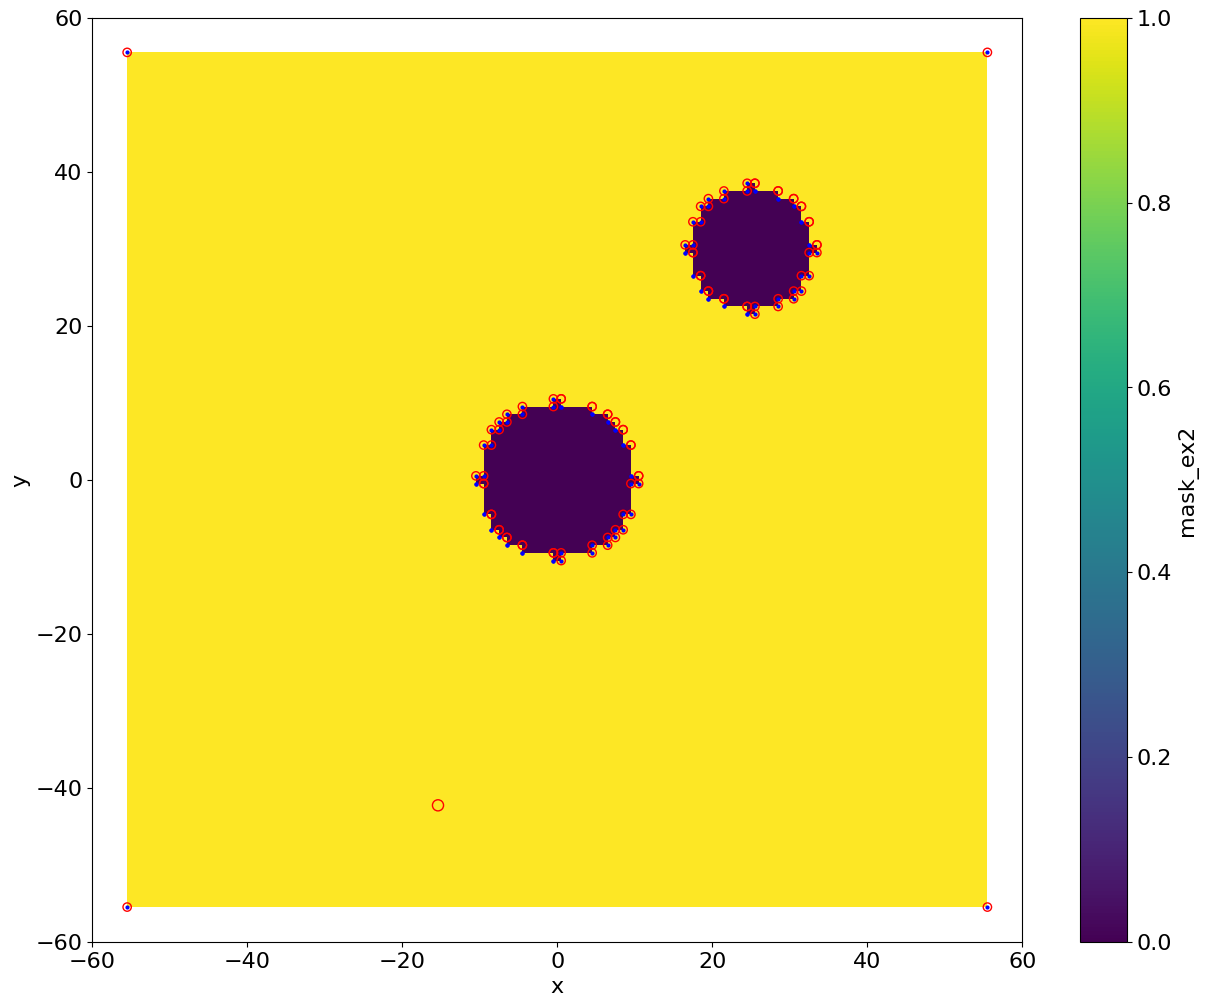

In [473]:
# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)
# ds[exC2.name].plot()

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[..., 0, 0], edge_pool[..., 0, 1], color="blue", s=2**2)
plt.scatter(edge_pool[..., 1, 0], edge_pool[..., 1, 1], facecolors="none", edgecolors="red", s=6**2)
# plt.scatter(boundary_pool[..., 0, 0], boundary_pool[..., 0, 1], color="deeppink", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

In [504]:
val = ex.mask.sel(x=0.1, y=0, method="nearest")
if not val:
    print(val)

<xarray.DataArray 'mask' ()> Size: 1B
array(False)
Coordinates:
    x        float64 8B 0.0
    y        float64 8B 0.0


#### Calcualte & Plot Unique Corner Rays

In [474]:
def _build_corner_rays(self, edge_pool):
    # collect unique edge points (i.e. unique (x,y) coords of edge
    # segment start and stop locations)
    edge_points = edge_pool.reshape(-1, 2)
    edge_points = np.unique(edge_points, axis=0)

    corner_rays = edge_points - self.insertion_point

    # sort corner_rays and edge_points corresponding to the ray angle
    delta = edge_points - self.insertion_point[np.newaxis, :]
    perp_indices = np.where(delta[..., 0] == 0)[0]
    if perp_indices.size > 0:
        delta[perp_indices, 0] = 1  # dx
        delta[perp_indices, 1] = np.inf * (
                delta[perp_indices, 1] / np.abs(delta[perp_indices, 1])
        )  # dy
    ray_angles = np.arctan(delta[..., 1] / delta[..., 0])
    sort_i = np.argsort(ray_angles)
    corner_rays = corner_rays[sort_i]
    edge_points = edge_points[sort_i]

    return corner_rays

In [475]:
def _build_corner_ray_mask(self, corner_rays, edge_pool):
    edge_vectors = edge_pool[..., 1, :] - edge_pool[..., 0, :]

    # determine if a corner_ray intersects an edge that is closer
    # to the insertion point
    # - solving the eqn:
    #
    #   insertion_point + mu * corner_ray = edge_pool[..., 0, :] + nu * edge_vector
    #
    #   * mu and nu are scalars
    #   * if 0 < mu < 1 and 0 < nu < 1, then the corner_ray passes through a
    #     closer edge to the insertion point
    #
    mu_array = (
            np.cross(edge_pool[..., 0, :] - self.insertion_point, edge_vectors)
            / np.cross(corner_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
    )
    nu_array = (
            np.cross(
                (self.insertion_point - edge_pool[..., 0, :])[:, np.newaxis, ...],
                corner_rays
            ).swapaxes(0, 1)
            / np.cross(edge_vectors[:, np.newaxis, ...], corner_rays).swapaxes(0, 1)
    )
    mu_condition = np.logical_and(mu_array >= 0, mu_array < 1)
    nu_condition = np.logical_and(nu_array >= 0, nu_array <= 1)
    _condition = np.logical_and(mu_condition, nu_condition)
    _count = np.count_nonzero(_condition, axis=1)

    return _count == 0

In [476]:
corner_rays = _build_corner_rays(ex, edge_pool)
ray_mask = _build_corner_ray_mask(ex, corner_rays, edge_pool)
corner_rays = corner_rays[ray_mask]
(corner_rays.shape, ray_mask.shape)

((26, 2), (100,))

In [477]:
end_points = corner_rays + ex.insertion_point[np.newaxis, :]
end_points.shape

(26, 2)

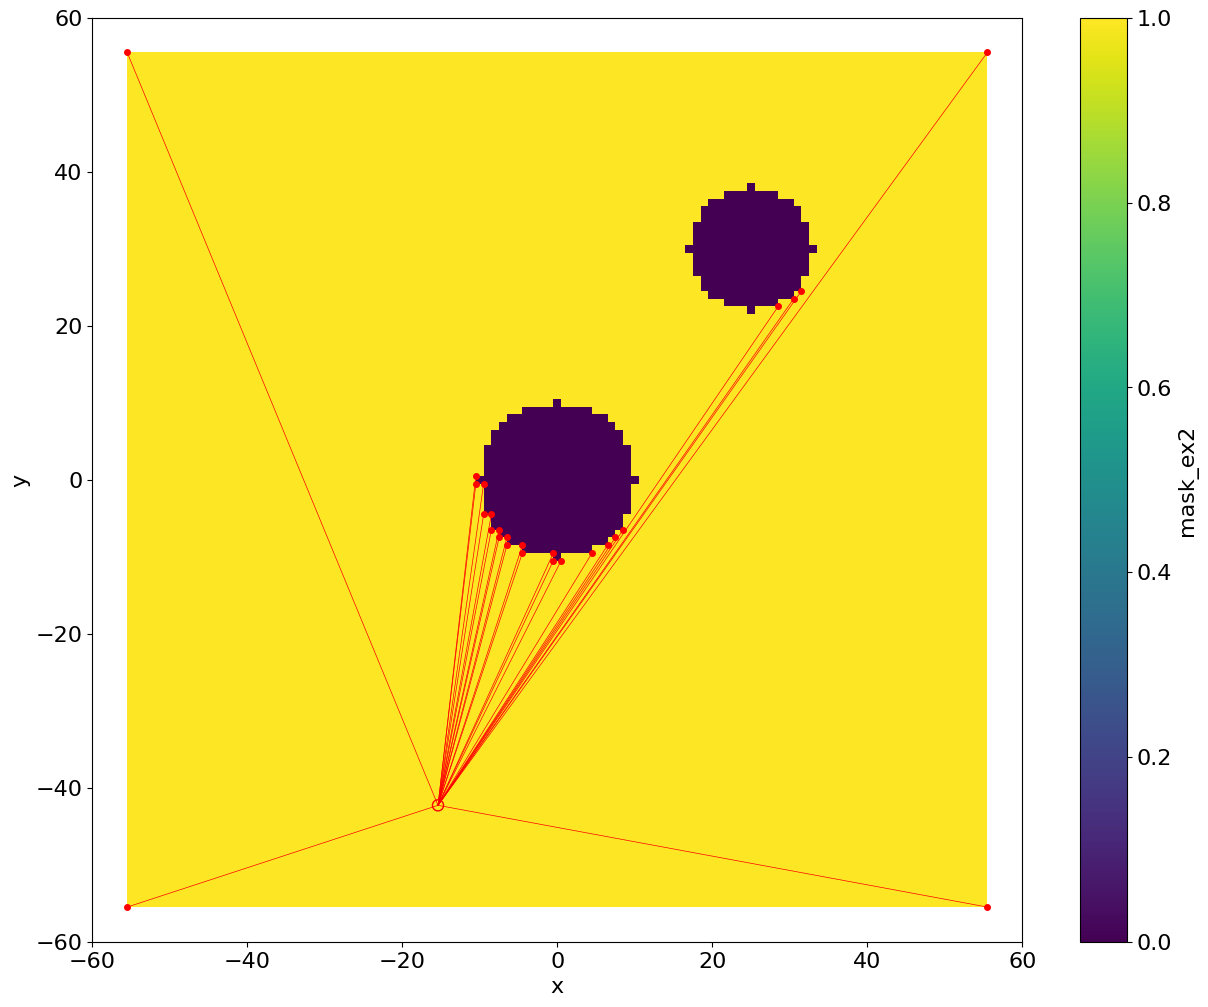

In [478]:
# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(end_points[..., 0], end_points[..., 1], color="red", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

for ii in range(end_points.shape[0]):
    plt.plot(
        [ex.insertion_point[0], end_points[ii, 0]],
        [ex.insertion_point[1], end_points[ii, 1]],
        color="red",
        linewidth=0.5,
    )

#### Generate Fanned Rays

In [479]:
def _build_fan_rays(self, corner_rays, edge_pool):
    dx, dy = self.mask_resolution
    
    # calculate angles of corner_rays
    angles = np.arcsin(corner_rays[..., 1] / np.linalg.norm(corner_rays, axis=1))
    corner_ray_angles = np.where(corner_rays[..., 0] >=0, angles, np.pi - angles)
    
#     delta_angle = 0.02 * np.sqrt(dx**2 + dy**2) / np.linalg.norm(corner_rays, axis=1)
    delta_angle = 0.02 * np.min(self.mask_resolution) / np.linalg.norm(corner_rays, axis=1)
    
    # generate fanned rays
    fan_plus = np.linalg.norm(corner_rays, axis=1) * [
        np.cos(corner_ray_angles + delta_angle),
        np.sin(corner_ray_angles + delta_angle),
    ]
    fan_plus = fan_plus.swapaxes(0,1)

    fan_minus = np.linalg.norm(corner_rays, axis=1) * [
        np.cos(corner_ray_angles - delta_angle),
        np.sin(corner_ray_angles - delta_angle),
    ]
    fan_minus = fan_minus.swapaxes(0,1)

    fan_rays = np.concatenate(
        (fan_plus, fan_minus),
        axis=0,
    )
    
    # sort fan rays
    ray_angles = np.arcsin(fan_rays[..., 1] / np.linalg.norm(fan_rays, axis=1))
    ray_angles = np.where(fan_rays[..., 0] >=0, ray_angles, np.pi - ray_angles)
    sort_i = np.argsort(ray_angles)
    fan_rays = fan_rays[sort_i]
    
    # project fan rays to the nearest edge
    edge_vectors = edge_pool[..., 1, :] - edge_pool[..., 0, :]
    
    mu_array = (
        np.cross(edge_pool[..., 0, :] - self.insertion_point, edge_vectors) 
        / np.cross(fan_rays, edge_vectors[:, np.newaxis, ...]).swapaxes(0, 1)
    )
    
    nu_array = (
        np.cross((self.insertion_point - edge_pool[..., 0, :])[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
        / np.cross(edge_vectors[:, np.newaxis, ...], fan_rays).swapaxes(0, 1)
    )
    
    mu_condition = mu_array > 0
    nu_condition = np.logical_and(nu_array >= 0, nu_array <= 1)
    mask = np.logical_and(mu_condition, nu_condition)
    
    mu_array[np.logical_not(mask)] = np.inf
    adjusted_mu_array = np.nanmin(mu_array, axis=1)
    
    # filter rays that go to infinity (these rays never enter the motion space)
#     finite_mask = np.isfinite(adjusted_mu_array)
    
#     fan_rays = adjusted_mu_array[finite_mask, None] * fan_rays[finite_mask, :]
    fan_rays = adjusted_mu_array[..., None] * fan_rays
    
    return fan_rays
    

In [480]:
fan_rays = _build_fan_rays(ex, corner_rays, edge_pool)
(
    corner_rays.shape,
    fan_rays.shape,
)

((26, 2), (52, 2))

In [481]:
dx, dy = ex.mask_resolution
(
    np.isclose(fan_rays[1::2, 0], corner_rays[..., 0], atol=.95 * dx),
    np.isclose(fan_rays[1::2, 1], corner_rays[..., 1], atol=.95 * dy),
)

(array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False]))

In [482]:
def _merge_corner_and_fan_rays(self, corner_rays, fan_rays):
    # filter close points before merging
    dx, dy = ex.mask_resolution
    mask1 = np.logical_and(
        np.isclose(fan_rays[0::2, 0], corner_rays[..., 0], atol=.5 * dx),
        np.isclose(fan_rays[0::2, 1], corner_rays[..., 1], atol=.5 * dy),
    )
    mask2 = np.logical_and(
        np.isclose(fan_rays[1::2, 0], corner_rays[..., 0], atol=.5 * dx),
        np.isclose(fan_rays[1::2, 1], corner_rays[..., 1], atol=.5 * dy),
    )
    mask = np.ones((fan_rays.shape[0],), dtype="bool")
    mask[0::2] = np.logical_not(mask1)
    mask[1::2] = np.logical_not(mask2)
    _fan_rays = fan_rays[mask]
    finite_mask = np.all(np.isfinite(_fan_rays), axis=1)
    _fan_rays = _fan_rays[finite_mask]
    
    # merge rays
    _rays = np.concatenate((corner_rays, _fan_rays), axis=0)
    
    # sort rays by angle
    angles = np.arcsin(_rays[..., 1] / np.linalg.norm(_rays, axis=1))
    angles = np.where(_rays[..., 0] >=0, angles, np.pi - angles)
    sort_i = np.argsort(angles)
    _rays = _rays[sort_i]
    
    return _rays

In [483]:
rays = _merge_corner_and_fan_rays(ex, corner_rays, fan_rays)
rays.shape

(78, 2)

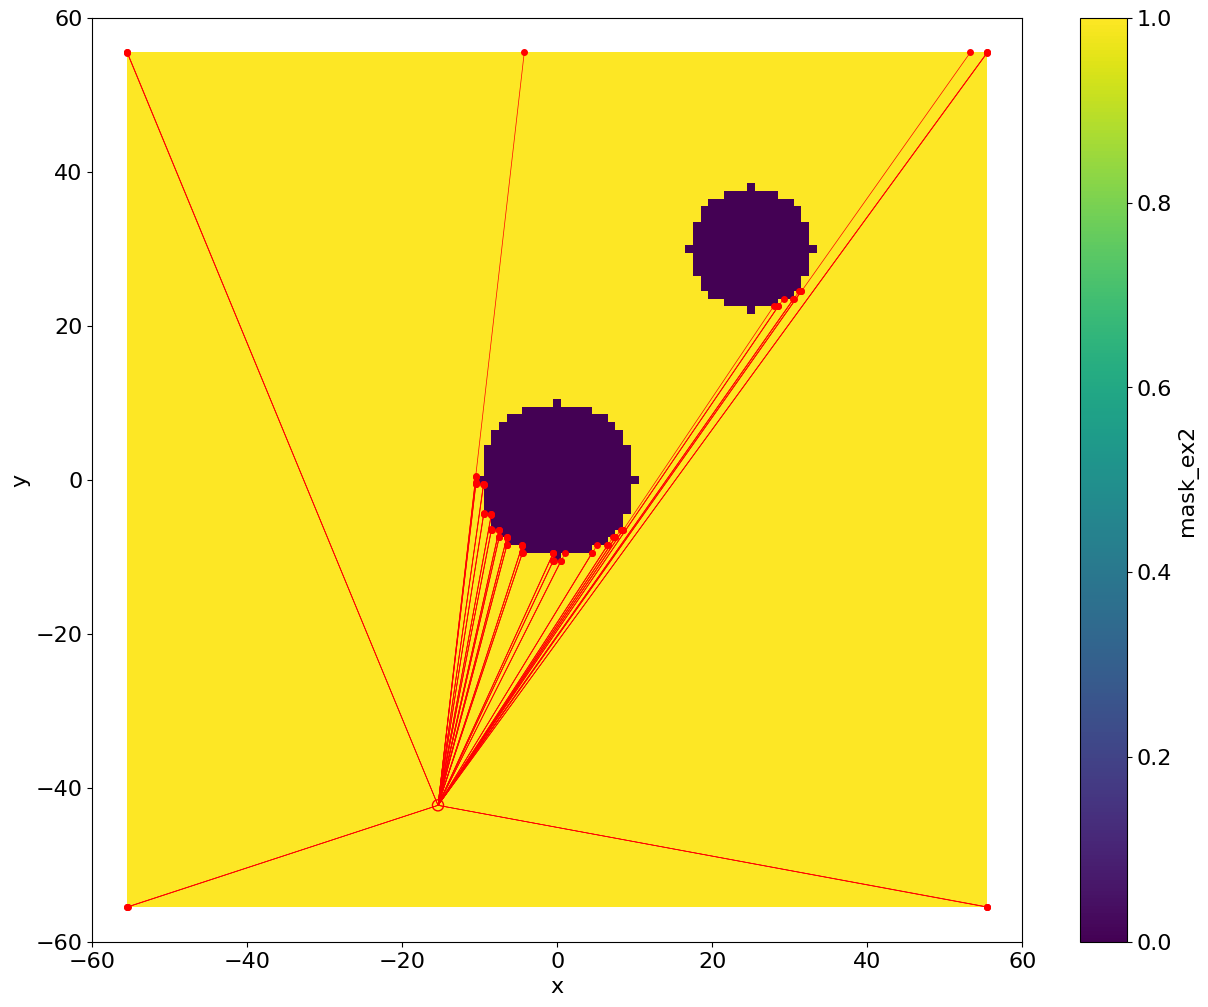

In [484]:
end_points = rays + ex.insertion_point[np.newaxis, :]
end_points.shape

# ds.mask.plot(x="x", y="y", aspect=1.25, size=12)
mask.plot(x="x", y="y", aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(end_points[..., 0], end_points[..., 1], color="red", s=4**2)
plt.scatter(ex.insertion_point[0], ex.insertion_point[1], facecolors="none", edgecolors="red", s=8**2)

for ii in range(end_points.shape[0]):
    plt.plot(
        [ex.insertion_point[0], end_points[ii, 0]],
        [ex.insertion_point[1], end_points[ii, 1]],
        color="red",
        linewidth=0.5,
    )

# plt.scatter(fan_ray_endpoints[..., 0], fan_ray_endpoints[..., 1], color="blue", s=4**2)

#### Paint Mask

In [485]:
def _paint_mask(self, rays: np.ndarray):
    
    x_key, y_key = self.mspace_dims
    x_coord = self.mspace_coords[x_key]
    y_coord = self.mspace_coords[y_key]
    
    rays = np.append(rays, rays[0,...][None, ...], axis=0)
    endpoints = rays + self.insertion_point[None, :]
    
    triangles = np.zeros((rays.shape[0] - 1, 3, 2))
    triangles[..., 0, :] = self.insertion_point
    triangles[..., 1, :] = endpoints[:-1, :]
    triangles[..., 2, :] = endpoints[1:, :]
    
    grid_points = np.zeros((x_coord.size, y_coord.size, 2))
    grid_points[..., 0] = np.repeat(x_coord.values[..., np.newaxis], y_coord.size, axis=1)
    grid_points[..., 1] = np.repeat(y_coord.values[np.newaxis, ...], x_coord.size, axis=0)
    
    # This processes used Barycentric coordinates to determin if a grid point is within
    # the triangle.
    #
    # https://en.wikipedia.org/wiki/Barycentric_coordinate_system
    #
    # lambda shape is (x_size, y_size, N_rays)
    num = np.cross(
        grid_points[:, :, None, :] - triangles[None, None, :, 0, :],
        (triangles[:, 1, :] - triangles[:, 0, :])[None, None, :, :],
    )
    denom = np.cross(
        triangles[:, 2, :] - triangles[:, 0, :],
        triangles[:, 1, :] - triangles[:, 0, :]
    )
    lambda_3 = num / denom[None, None, ...]
    
    num  = np.cross(
        grid_points[:, :, None, :] - triangles[None, None, :, 0, :],
        (triangles[:, 2, :] - triangles[:, 0, :])[None, None, :, :],
    )
#     denom = np.cross(
#         triangles[:, 1, :] - triangles[:, 0, :],
#         triangles[:, 2, :] - triangles[:, 0, :]
#     )
    denom = -denom

    lambda_2 = num / denom[None, None, ...]
    
    lambda_1 = 1 - lambda_2 - lambda_3
    
    lambda_1_condition = np.logical_and(lambda_1 >= 0, lambda_1 <= 1)
    lambda_2_condition = np.logical_and(lambda_2 >= 0, lambda_2 <= 1)
    lambda_3_condition = np.logical_and(lambda_3 >= 0, lambda_3 <= 1)
    
    _condition = np.logical_and(
        np.logical_and(lambda_1_condition, lambda_2_condition),
        lambda_3_condition,
    )
    
    return np.any(_condition, axis=2)

In [486]:
shadow_mask = _paint_mask(ex, rays)

In [487]:
x_key, y_key = ex.mspace_dims
x_coord = ex.mspace_coords[x_key]
y_coord = ex.mspace_coords[y_key]
ds["shadow"] = xr.DataArray(
    data=shadow_mask,
    coords={x_key: x_coord, y_key: y_coord},
)

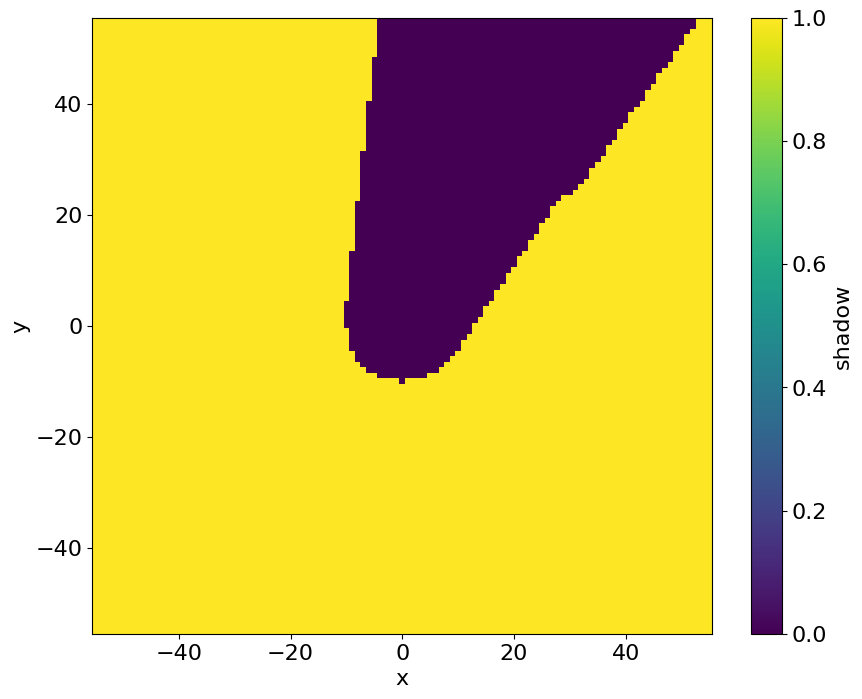

In [488]:
ds.shadow.plot(x="x", y="y")

## Create LaPD XY exclusion mask using elementry exclusions

Create the seeding boolean mask.  In the boolean mask a `True` value indicates a point allowed for a motion list and a `False` value indicaes an exclusion zone.

In [ ]:
ex._ds

In [ ]:
ex.mask_resolution

In [ ]:
ex.composed_exclusions
for subex in ex.composed_exclusions:
    print(subex.name)

Additionally, port locations can be specified using values of `E`, `East`, `W`, `West`, `T`, `Top`, `B`, and `Bottom` (all are case insensitive).

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location="T")

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

For non-standard ports an angle (in degrees) can be given instead.

In [ ]:
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ex = LaPDXYExclusion(ds, port_location=135)

ds.mask.plot(x="x", y="y")

mb = ex.composed_exclusions[1].mb
plt.plot(side, mb[0] * side + mb[1], color="blue")

mb = ex.composed_exclusions[2].mb
plt.plot(side, mb[0] * side + mb[1], color="red");

`LaPDXYExclusion` is a compound exclusiong, that is it is constructed from other base exclusions.  In this case, it build used one instance of the `CircularExclusion` and two instances of the `DividerExclusion`.

In [ ]:
ex.composed_exclusions

Just like base exclusesion, the `LaPDXYExclusion` configuration can be accesed via the `config` attribute.

In [ ]:
ex.config

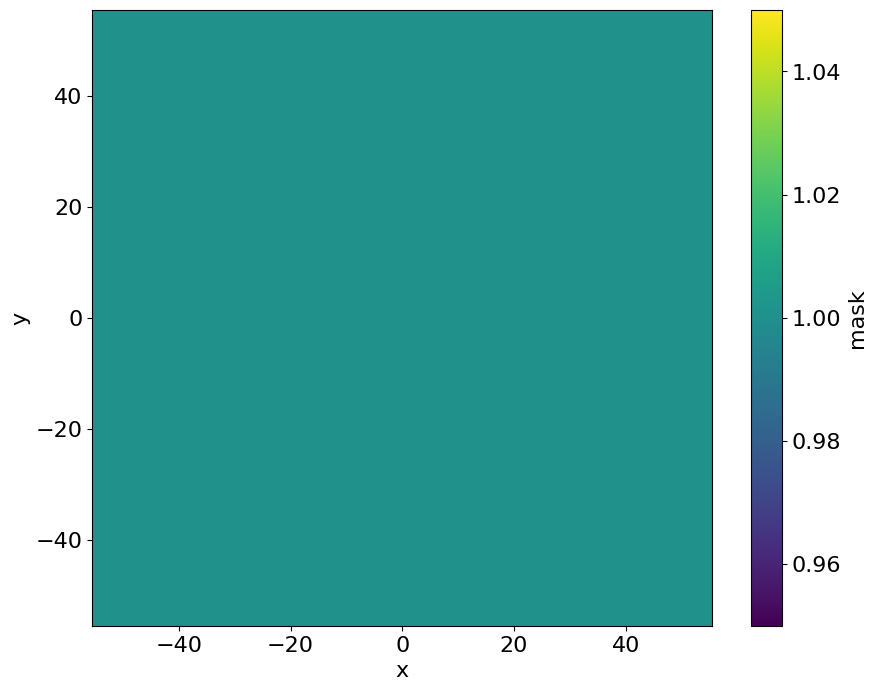

In [11]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

The default settings for the for `LaPDXYExclusion` are the same as the manually constructed exclusion mask above.

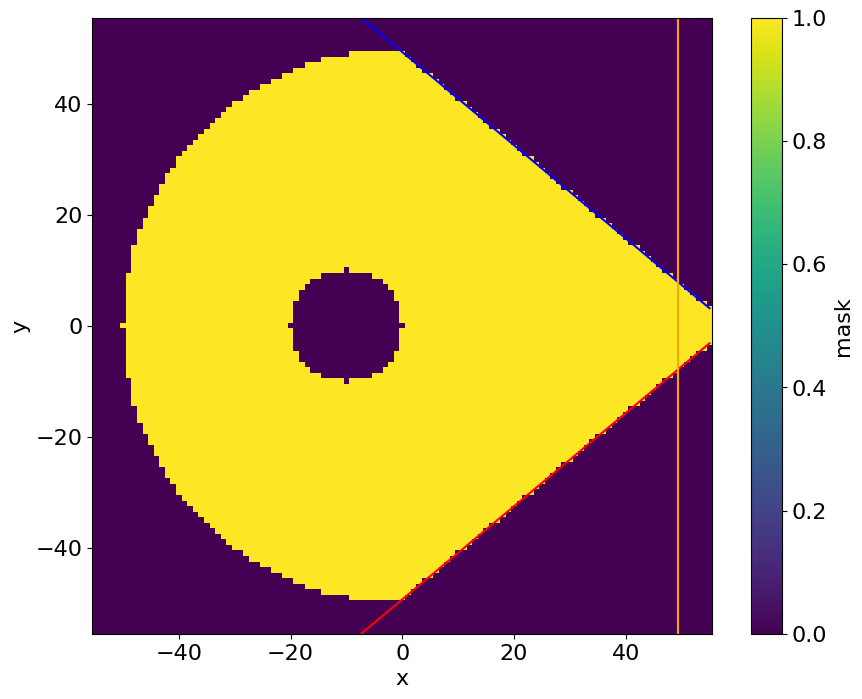

In [12]:
ex = LaPDXYExclusion(ds)
exC = CircularExclusion(ds, radius=10, center=(-10,0), exclude="inside")

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;

In [16]:
edge_pool = ex._build_edge_pool(ds.mask)

TypeError: LaPDXYExclusion._build_edge_pool() got an unexpected keyword argument 'axis'

In [23]:
edge_points = edge_pool.reshape(-1, 2)

In [26]:
edge_points = np.unique(edge_points, axis=0)

In [28]:
edge_points - ex.insertion_point[np.newaxis, :]

array([[-109.271,   -0.5  ],
       [-109.271,    0.5  ],
       [-108.271,   -9.5  ],
       [-108.271,   -0.5  ],
       [-108.271,    0.5  ],
       [-108.271,    9.5  ],
       [-107.271,  -14.5  ],
       [-107.271,   -9.5  ],
       [-107.271,    9.5  ],
       [-107.271,   14.5  ],
       [-106.271,  -17.5  ],
       [-106.271,  -14.5  ],
       [-106.271,   14.5  ],
       [-106.271,   17.5  ],
       [-105.271,  -19.5  ],
       [-105.271,  -17.5  ],
       [-105.271,   17.5  ],
       [-105.271,   19.5  ],
       [-104.271,  -21.5  ],
       [-104.271,  -19.5  ],
       [-104.271,   19.5  ],
       [-104.271,   21.5  ],
       [-103.271,  -23.5  ],
       [-103.271,  -21.5  ],
       [-103.271,   21.5  ],
       [-103.271,   23.5  ],
       [-102.271,  -25.5  ],
       [-102.271,  -23.5  ],
       [-102.271,   23.5  ],
       [-102.271,   25.5  ],
       [-101.271,  -27.5  ],
       [-101.271,  -25.5  ],
       [-101.271,   25.5  ],
       [-101.271,   27.5  ],
       [-100.2

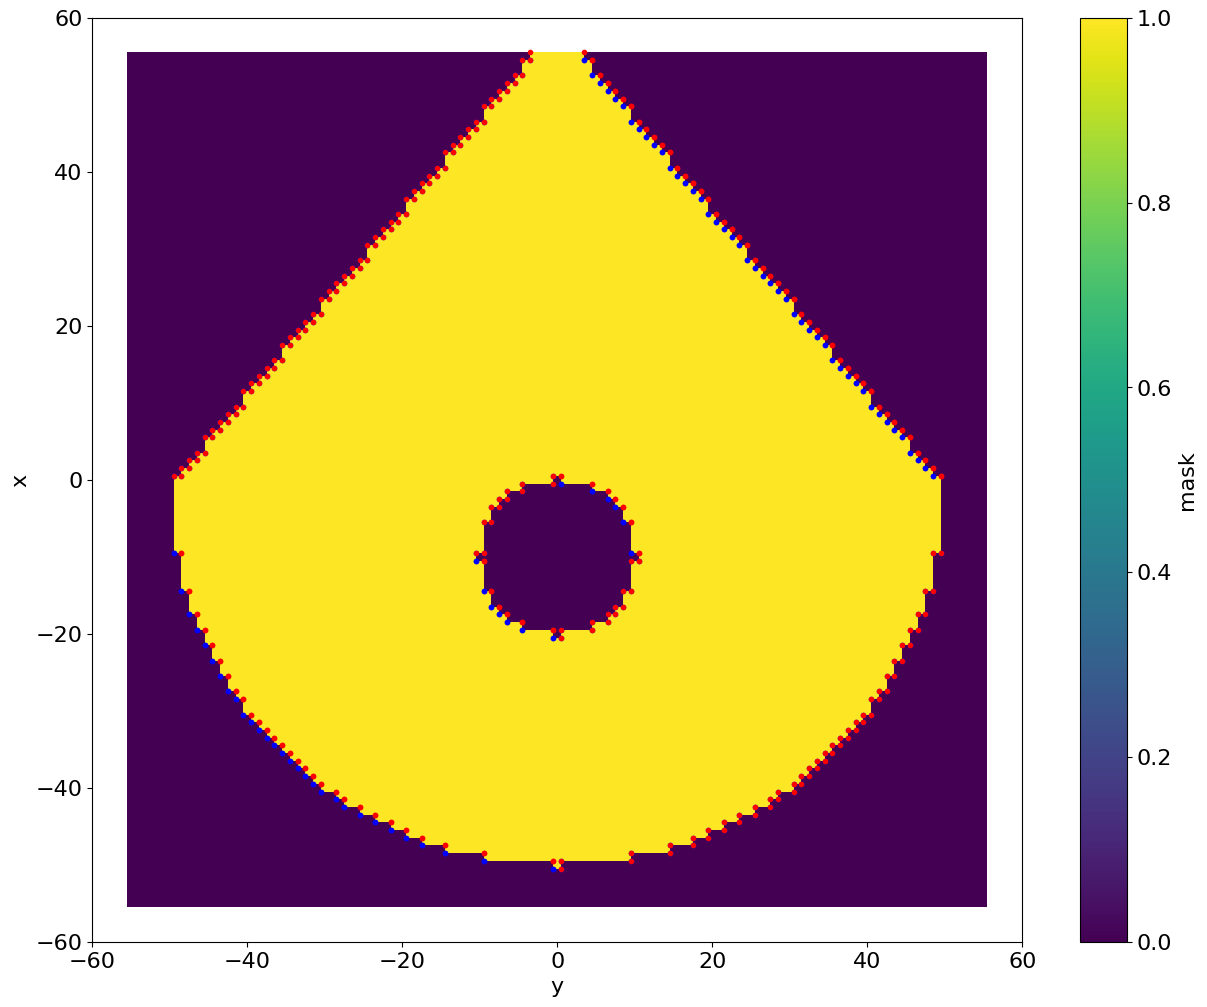

In [14]:
ds.mask.plot(aspect=1.25, size=12)

ax = plt.gca()
ax.set_ylim(-60, 60)
ax.set_xlim(-60, 60)

plt.scatter(edge_pool[..., 0, 1], edge_pool[..., 0, 0], color="blue", s=3**2)
plt.scatter(edge_pool[..., 1, 1], edge_pool[..., 1, 0], color="red", s=3**2)

In [6]:
from bapsf_motion.motion_builder.exclusions import Shadow2DExclusion, CircularExclusion

Create a staring blank (all `True`) mask.

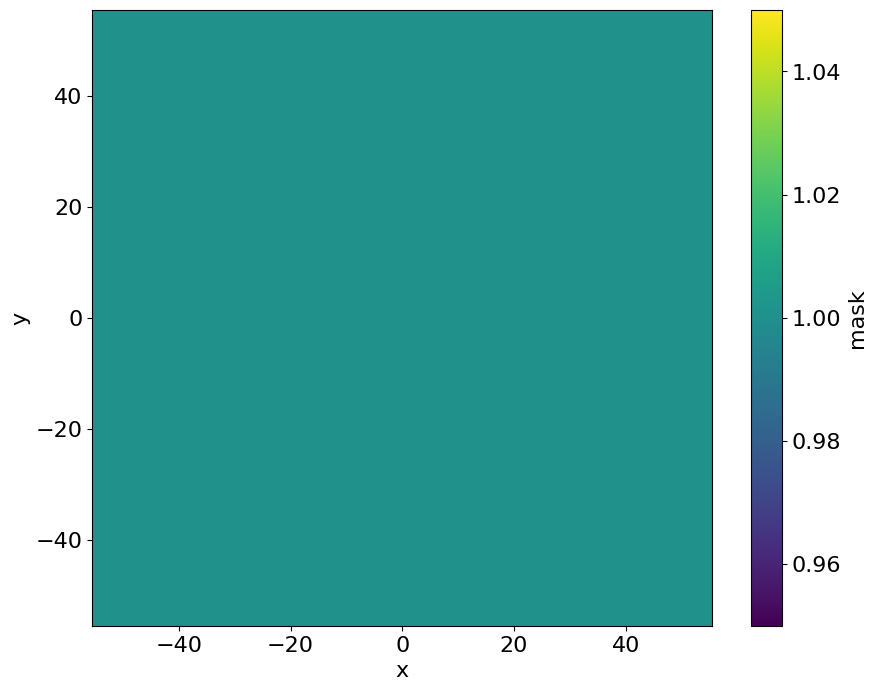

In [7]:
size = 111
side = np.linspace(-55, 55, num=size)
ds = xr.Dataset(
    {"mask": (("x", "y"), np.ones((size, size), dtype=bool))},
    coords={
        "x": side,
        "y": side,
    },
)

ds.mask.plot(x="x", y="y");

Populate the mask with a `LaPDXYExclusion` and `CircularExclusion`.  `CircularExclusion` is the element we will want to shadow.

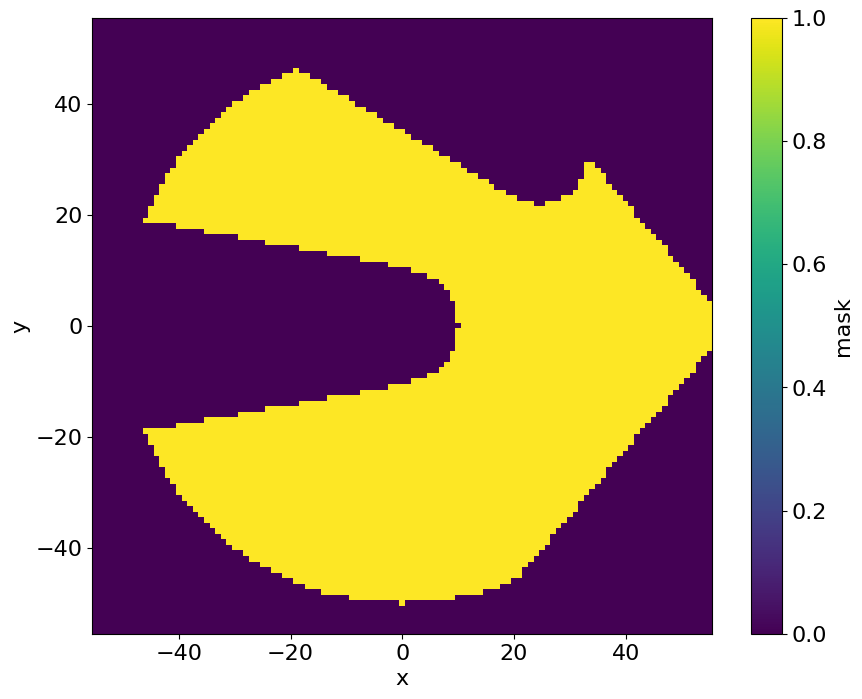

In [8]:
exC = CircularExclusion(ds, radius=10, center=(0,0), exclude="inside")
exC2 = CircularExclusion(ds, radius=8, center=(25,30), exclude="inside")
# ex = Shadow2DExclusion(ds, insertion_point=[40,-40])
ex = LaPDXYExclusion(ds, cone_full_angle=100)

ds.mask.plot(x="x", y="y")

colors = ["blue", "red", "orange"]
ii = 0
for subex in ex.composed_exclusions:
    if not isinstance(subex, DividerExclusion):
        continue

    (slope, intercept) = subex.mb
    color = colors[np.mod(ii, len(colors))]
    if np.isinf(slope):
        ylim = plt.gca().get_ylim()
        plt.vlines(intercept, *ylim, color=color)
    else:
        plt.plot(side, slope * side + intercept, color=color)

    ii += 1;